# Introduction

> **Problem Statement:**
> We have been provided with thousands of sixty-second sequences of biological sensor data recorded from several hundred participants who could have been in either of two possible activity states.

> **Evaluation:** Submissions will be evaluated on area under the ROC curve between the predicted probability and the observed target.

> **Files and Field Descriptions:** There are 3 files, which we need to work on. For training, we will have to combine train & train_labels file.
> 1. **train** - This is the training dataset, comprising 25,968 60-second recordings of thirteen biological sensors.0
>     * sequence - a unique id for each sequence
>     * subject - a unique id for the subject in the experiment
>     * step - time step of the recording, in one second intervals
>     * sensor_00 - sensor_12 - the value for each of the thirteen sensors at that time step
> 2. **train_labels** - This is file which is mapped to train file, and have target variable.
>     * sequence - the unique id for each sequence.
>     * state - This is the target variable which is associated to each sequence. 
> 3. **test** - This is test dataset, compromising 12,218 sequences, need to predict a value for that sequence's state.

**Conclusion**
1. As mentioned in problem statement, this is a time series classification problem. We will be solving this problem with LSTM.
1. Training file have exact 25968 * 60 records, so exact 15,58,080 records. Testing file have 7,33,080 records.

# Data Extraction & Analysis

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling1D,BatchNormalization,Dense, Dropout, Input,Concatenate, LSTM, GRU,Bidirectional, Multiply

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GroupKFold

In [ ]:
BASE_PATH='../input/tabular-playground-series-apr-2022/'
train_df =pd.read_csv(BASE_PATH + 'train.csv')
train_label_df =pd.read_csv(BASE_PATH +'train_labels.csv')
test_df =pd.read_csv(BASE_PATH +'test.csv')
op_df = pd.read_csv(BASE_PATH +'sample_submission.csv')

In [ ]:
train_df.shape,train_label_df.shape,test_df.shape

In [ ]:
train_df.head(5)

In [ ]:
train_label_df.head(5)

In [ ]:
train_df.info()

In [ ]:
n = train_df.nunique(axis=0)  
print("No.of.unique values in each column :\n", n)

In [ ]:
train_df.describe()

**Duplicate record check**

In [ ]:
duplicate = train_df[train_df.duplicated(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12'])]
print(duplicate.count())

In [ ]:
duplicate.head(10)

In [ ]:
duplicate.nunique(axis=0)

**Conclusion**
1. There are no missing records.
1. We have 56 records, which have duplicate records.Looks like most of the sensors value remains same for them.


# EDA

In [ ]:
sns.countplot(data = train_label_df, x='state')

In [ ]:
bp_df = train_df.copy()
bp_df = bp_df.drop(['sequence','subject','step'], axis=1)
bp_df.boxplot(grid=False, rot=60, fontsize=15,figsize= (12,10))

In [ ]:
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(train_df[sensor_name], bins=100)
    plt.title(f"{sensor_name} histogram")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Sensor Histograms Before Outlier Removal', y=1.02)
plt.show()

In [ ]:
sequences = [0, 1, 2, 8364, 15404]
figure, axes = plt.subplots(13, len(sequences), sharex=True, figsize=(16, 16))
for i, sequence in enumerate(sequences):
    for sensor in range(13):
        sensor_name = f"sensor_{sensor:02d}"
        plt.subplot(13, len(sequences), sensor * len(sequences) + i + 1)
        plt.plot(range(60), train_df[train_df.sequence == sequence][sensor_name],
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10])
        if sensor == 0: plt.title(f"Sequence {sequence}")
        if sequence == sequences[0]: plt.ylabel(sensor_name)
figure.tight_layout(w_pad=0.1)
plt.suptitle('Time Series', y=1.02)
plt.show()

**Conclusion**
1. Target variable is very balanced.
1. Sensor data is not normally distributed.
1. Most time series have a waveform with a high frequency. "High frequency" means that the value changes between positive and negative almost at every sampling step.
1. We do have few outliers.

# Feature Engineering

In [ ]:
def prep(df):
    sensor_features = df.columns.tolist()[3:]
    for feature in sensor_features:
        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1)
        df.fillna(0, inplace=True)
        df[feature + '_diff1'] = df[feature] - df[feature + '_lag1']

In [ ]:
prep(train_df)
prep(test_df)

In [ ]:
train_df.head(5)

Lets Standardize data with StandardScalar, which standardize features by removing the mean and scaling to unit variance.
The standard score of a sample x is calculated as:

    z = (x - u) / s
Where,
* u: the mean of the training samples or zero if with_mean=False 
* s: the standard deviation of the training samples or one if with_std=False.

In [ ]:
sc = StandardScaler()
features = train_df.columns.tolist()[3:]
train_df[features] = sc.fit_transform(train_df[features])
test_df[features] = sc.transform(test_df[features])

In [ ]:
train_df.head(2)

In [ ]:
groups = train_df["sequence"]
labels = train_label_df["state"]

train_df = train_df.drop(["sequence", "subject", "step"], axis=1).values
train_df = train_df.reshape(-1, 60, train_df.shape[-1])

test_df = test_df.drop(["sequence", "subject", "step"], axis=1).values
test_df = test_df.reshape(-1, 60, test_df.shape[-1])

print(train_df.shape, test_df.shape)

# LSTM

**What is LSTM?**

Long Short Term Memory Network (LSTM) is an advanced Recurrent Neural Network, a sequential network, that allows information to persist. It is capable of handling the vanishing gradient problem faced by RNN. 

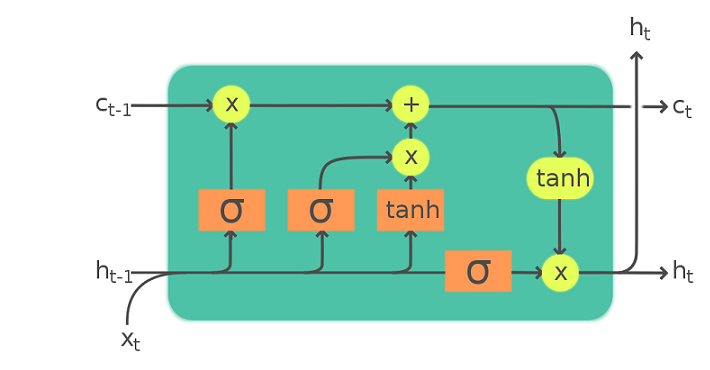

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. 

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 256
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

In [ ]:
def dnn_model():    
    x_input = Input(shape=(train_df.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)
    z1 = Bidirectional(GRU(units=256, return_sequences=True))(x1)
    c = Concatenate(axis=2)([x2, z1])    
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)    
    x4 = GlobalMaxPooling1D()(x3)
    x5 = Dense(units=128, activation='selu')(x4)
    x6 = Dropout(0.1)(x5)
    x_output = Dense(1, activation='sigmoid')(x6)
    model = Model(inputs=x_input, outputs=x_output, name='lstm_model')
    
    return model

In [ ]:
with tpu_strategy.scope():
    VERBOSE = False
    predictions, scores = [], []
    k = GroupKFold(n_splits = 10)

    for fold, (train_idx, val_idx) in enumerate(k.split(train_df, labels, groups.unique())):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    
        X_train, X_val = train_df[train_idx], train_df[val_idx]
        y_train, y_val = labels.iloc[train_idx].values, labels.iloc[val_idx].values
        
        model = dnn_model()
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics='AUC')

        lr = ReduceLROnPlateau(monitor="val_auc", factor=0.6,  patience=4, verbose=VERBOSE)

        es = EarlyStopping(monitor="val_auc", patience=7,  verbose=VERBOSE, mode="max", restore_best_weights=True)
        
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        chk_point = ModelCheckpoint(f'./TPS_model_2022_{fold+1}C.h5', options=save_locally, 
                                    monitor='val_auc', verbose=VERBOSE,save_best_only=True, mode='max')
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, verbose=VERBOSE,
                  batch_size=BATCH_SIZE, callbacks=[lr, chk_point, es])
        
        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(f'./TPS_model_2022_{fold+1}C.h5', options=load_locally)
        
        y_pred = model.predict(X_val, batch_size=BATCH_SIZE).squeeze()
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
        predictions.append(model.predict(test_df, batch_size=BATCH_SIZE).squeeze())
        print(f"Fold-{fold+1} | OOF Score: {score}")
    
    print(f'Mean accuracy on {k.n_splits} folds - {np.mean(scores)}')

In [ ]:
op_df["state"] = sum(predictions)/k.n_splits 
op_df.head(3)

In [ ]:
op_df.to_csv('submission.csv', index=False)

This notebook have taken lot of inspiration from below incredible work,
1. https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense#The-sensors From: [AmbrosM](https://www.kaggle.com/ambrosm)
1. https://www.kaggle.com/code/kartushovdanil/top-1-tps-apr-22-eda-lstm#LSTM  From: [Torch Me](https://www.kaggle.com/kartushovdanil)
1. https://en.wikipedia.org/wiki/Long_short-term_memory